In [1]:
import pandas as pd 
df = pd.read_csv("cc3m_full_with_path.csv")

In [2]:
df

,url,key,status,width,height,exif,caption,alt_txt,path
0,https://ak0.picdn.net/shutterstock/videos/3380...,1470004,success,852.0,480.0,{},the effect of moving the large colored particl...,"""""",/home/temp/Desktop/ccm3_full/00147/001470004.jpg
1,https://ak9.picdn.net/shutterstock/videos/2377...,1470024,success,852.0,480.0,{},wing of an airplane passing over clouds at hig...,"""""",/home/temp/Desktop/ccm3_full/00147/001470024.jpg
2,https://ak7.picdn.net/shutterstock/videos/1292...,1470042,success,852.0,480.0,{},man holding the keys to her new car in a motor...,"""""",/home/temp/Desktop/ccm3_full/00147/001470042.jpg
3,https://ak9.picdn.net/shutterstock/videos/1147...,1470044,success,852.0,480.0,{},background with particles and stars .,"""""",/home/temp/Desktop/ccm3_full/00147/001470044.jpg
4,https://ak8.picdn.net/shutterstock/videos/5176...,1470039,success,852.0,480.0,{},food canned in mason jars on shelves in a stor...,"""""",/home/temp/Desktop/ccm3_full/00147/001470039.jpg
...,...,...,...,...,...,...,...,...,...
2555423,http://l7.alamy.com/zooms/5f24d20339df4077a506...,2199920,success,640.0,447.0,{},senior woman in the park,"""""",/home/temp/Desktop/ccm3_full/00219/002199920.jpg
2555424,http://l7.alamy.com/zooms/7c2ad41134dc4b1984d9...,2199914,success,640.0,446.0,{},remote house in the forest by lake,"""""",/home/temp/Desktop/ccm3_full/00219/002199914.jpg
2555425,http://l7.alamy.com/zooms/0dd49ace792a4db6be39...,2199999,success,640.0,448.0,{},wind blown tree on the beach,"""""",/home/temp/Desktop/ccm3_full/00219/002199999.jpg
2555426,http://l7.alamy.com/zooms/28f1e935be484181a90c...,2199994,success,640.0,447.0,{},snow covered city park in a winter day .,"""""",/home/temp/Desktop/ccm3_full/00219/002199994.jpg


In [2]:
from dataset import * 
from tqdm import tqdm 

/home/temp/miniconda3/envs/stanford_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torchvision import datasets, transforms
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Resize((224, 224))
    ])
dataset = Mnist(None, transform)

In [4]:
from PIL import ImageFont, ImageDraw, Image 

def render_text(txt:str, image_size: int=224, font_size: int = 16, max_chars=768,
                       background_brightness=127, text_brightness=0,
                       lower=True, monospace=False, spacing=1, min_width=4,
                       resize_method="area", max_width=28):
    if len(txt)> max_chars:
        txt = txt[:max_chars]
    if lower: 
        txt = txt.lower() 
    wrapper = textwrap.TextWrapper(width=max_width)
    lines = wrapper.wrap(txt) 
    new_txt = ""
    for line in lines: 
        new_txt+= line+'\n'
    image = Image.new("RGBA", (image_size*3,image_size*3), (background_brightness,background_brightness,background_brightness))
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("/home/temp/Desktop/CLIPPO/unifont-15.0.06.otf", font_size*3)
    draw.text((0, 0), new_txt, (text_brightness,text_brightness,text_brightness), font=font, spacing=spacing)
    img_resized = image.resize((image_size,image_size), Image.ANTIALIAS)
    return img_resized


In [5]:
import torch 
from network import CLIPPO
from tim_and_bert import * 
clippo = CLIP()
clippo = clippo.cpu()
clippo.load_state_dict(torch.load("/home/temp/Desktop/KD/CLIPPO/clip.pt")) 

<All keys matched successfully>

In [6]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.decomposition import PCA

In [14]:
features = []
labels_ar = [] 
clippo = clippo.cuda(1)
clippo.eval() 
valid_loader = torch.utils.data.DataLoader(dataset, 2000, shuffle=False, num_workers=32)
for images, labels in valid_loader: 
    with torch.no_grad():
        out, _= clippo(torch.tensor(labels).cuda(1), images.cuda(1))#.squeeze()
        out = out
        features.append(out)
        labels_ar.append(labels[None, :])

features = torch.concat(features).cpu().detach().numpy()
labels_ar = torch.concat(labels_ar, dim=1).detach().numpy()

/tmp/ipykernel_2145456/391383897.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, out= clippo(torch.tensor(labels).cuda(1), images.cuda(1))#.squeeze()


In [15]:
tsne = TSNE().fit_transform(features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

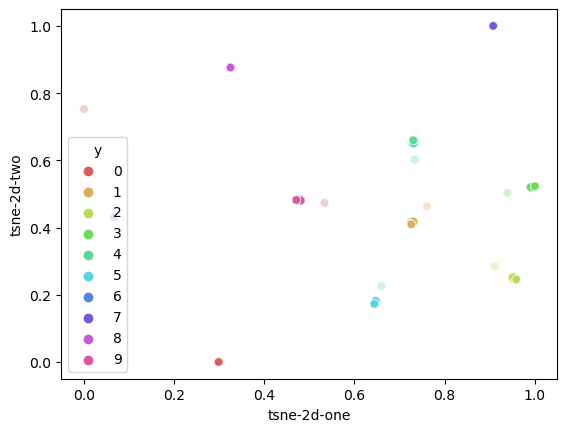

In [17]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.3
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

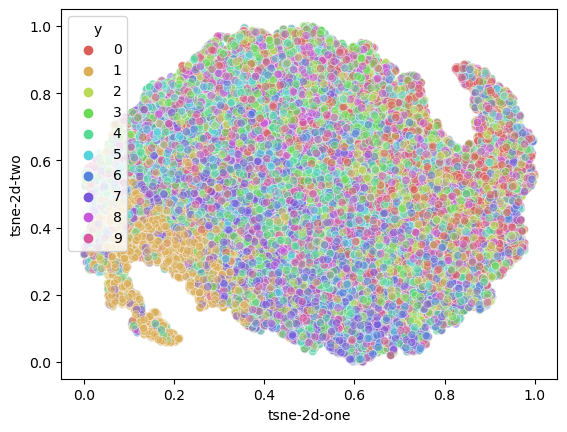

In [13]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.5
)

In [19]:
labels_ar.shape

(1, 60000)

In [20]:
features.shape

(60000, 512)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels_ar.squeeze(), test_size=0.33, random_state=42)

In [24]:
lr = LogisticRegression()

In [25]:
lr.fit(X_train, y_train)

/home/temp/miniconda3/envs/stanford_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

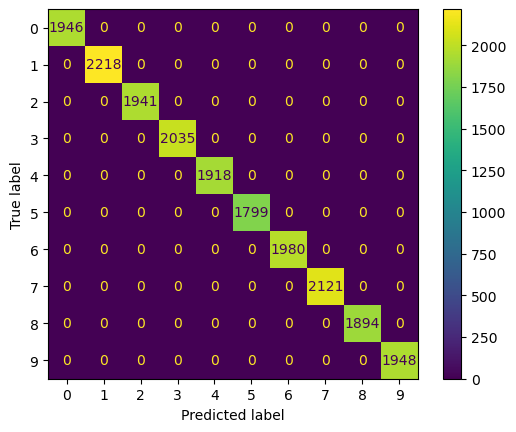

In [30]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)